# Predicting Population Growth in the next seven years

This project will take several major demographic factors from the American Cummunity Survey and use them to try and predict population growth seven years out (since that was the biggest gap I could find between the datasets) across the United States. Population growth at a micro scale (for instance, by census tract) is crucial for urban planning purposes- including planning public transit, schools, community funding, and more. 

I will use the various demographic measurements of each census tract in 2012 to predict the difference between the 2012 population and the 2019 population. I will then use that trained model to predict the population in 2026 off of the 2019 characteristics. I will probably use a Generalized Linear Model since those are most interpretable, but also will likely test out several other models to see which can give me the most accurate predictions. As a second stage, I would like to cluster the census tracts to see what are the different types of high-growth, medium-growth, flat, and negative areas. As a stretch, I would like to add in other locational datasets to see if I could improve the model, and/or apply my findings, in conjunction with locational data on climate change or location-based health metrics, to help advise governments on how to prepare for population movements. Additionally, I would like to deploy this as an app or on tableau, whichever makes the most sense.


In [60]:
# Imports 
import pandas as pd
import numpy as np
import censusdata
import mapclassify
import re
import fiona
import time
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt



### Data Gathering for 2012

Pulling in a selection of twenty demographic variables from the 2012 American Community Survey at the Census Tract level

In [285]:
# The variables starting with 'B' are various ACS demographic variables.
census2012 = pd.DataFrame()
for number in range(1,57):
    if number < 10:
        number = '0'+str(number)
    else: number = str(number)
    if number not in ['03','07','14','43','52']:
        tract_data = censusdata.download('acs5', 2012,
                                                 censusdata.censusgeo([('state', number), ('county', '*'), ('tract', '*')]),
                                                 ['B19013_001E', 'B03002_003E', 'B03002_001E', 'B03002_004E', 'B03002_012E',
                                                 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B23025_001E', 'B23025_002E',
                                                 'B23025_005E', 'B23025_003E', 'B25077_001E', 'B01001_002E', 'B01001_001E',
                                                 'B01003_001E', 'B11001_002E', 'B11001_001E', 'B99051_005E', 'B99051_001E',
                                                 'B01002_001E', 'B15003_017E', 'B15003_018E',
                                                 'B15003_019E', 'B15003_020E', 'B15003_021E', 'B15003_022E', 'B15003_023E',
                                                 'B15003_024E', 'B15003_025E', 'B15003_001E', 'B08301_010E', 'B08301_001E',
                                                 'B25002_003E', 'B25002_001E', 'B25064_001E', 'B25003_003E', 'B25003_001E',
                                                 'B25092_001E', 'B25071_001E'])
    census2012 = pd.concat([census2012, tract_data])

In [290]:
# Checking the size of the dataset
census2012.shape

(88374, 40)

### Formatting the rest of the variables:

In [291]:
# Something funky was happening with these columns so I had to reformat them
low_pov = [np.max(value) for value in census2012.C17002_002E] 
med_pov = [np.max(value) for value in census2012.C17002_003E]

pov = [low_pov[i]+ med_pov[i] for i in range(len(low_pov))]
assessed_pop = [np.max(value) for value in census2012.C17002_001E]

pov_perc = [(pov[i]/ assessed_pop[i] *100) for i in range(len(pov))]
len(pov_perc)

/Users/anizotti/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


88374

In [292]:
census2012['pct_in_poverty']= pov_perc

In [293]:
# Something funky was happening with these columns so I had to reformat them

lowmed_ed = [np.max(value) for value in census2012.B15003_022E] 
med_ed = [np.max(value) for value in census2012.B15003_023E]
highmed_ed = [np.max(value) for value in census2012.B15003_024E]
high_ed = [np.max(value) for value in census2012.B15003_025E]

ed = [lowmed_ed[i]+ med_ed[i] + highmed_ed[i] + high_ed[i] for i in range(len(low_ed))]
assessed_pop_ed = [np.max(value) for value in census2012.B15003_001E]

perc_bach = [(ed[i]/ assessed_pop_ed[i] *100) for i in range(len(ed))]
len(perc_bach)

/Users/anizotti/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


88374

In [294]:
census2012['pct_bachelors_degree']= perc_bach

In [295]:
# Calculate total population
census2012['total_population'] = census2012['B01003_001E']

# Calculate median household income
census2012['median_HH_income'] = census2012['B19013_001E']

# Calculate percent of the population that is non-Hispanic white
census2012['pct_non_Hisp_white'] = 100 * census2012['B03002_003E']/census2012['B03002_001E']

# Calculate percent of the population that is non-Hispanic black
census2012['pct_non_Hisp_black'] = 100 * census2012['B03002_004E']/census2012['B03002_001E']

# Calculate percent of the population that is Hispanic
census2012['pct_Hispanic'] = 100 * census2012.B03002_012E/census2012.B03002_001E

# Calculate labor force participation rate (percent of the population age 16+ that's in the labor force)
census2012['labor_force_part_rate'] = 100 * (census2012.B23025_002E)/census2012.B23025_001E

# Calculate unemployment rate (total unemployed workers as percent of total size of the labor force)
census2012['unemployment_rate'] = 100 * (census2012.B23025_005E)/census2012.B23025_003E

# Median home value, in dollars
census2012['median_home_value'] = census2012.B25077_001E

# Percent of the population that is male
census2012['pct_male'] = 100*census2012.B01001_002E/census2012.B01001_001E

# Percent of households that are family households (as opposed to non-family households)
census2012['pct_households_families'] = 100 * census2012.B11001_002E/census2012.B11001_001E

# Percent of the population that is foreign-born
census2012['pct_foreign_born'] = 100 * census2012.B99051_005E/census2012.B99051_001E

# Median age of the population
census2012['median_age'] = census2012.B01002_001E

# Percent of workers who use public transportation to get to work
census2012['pct_workers_using_public_transportation'] = 100 * (census2012.B08301_010E/census2012.B08301_001E)

# Percent of housing units that are vacant
census2012['pct_housing_units_vacant'] = 100 * census2012.B25002_003E/census2012.B25002_001E

# Median gross monthly rent, in $
census2012['median_gross_rent'] =  census2012.B25064_001E

# Percent of households that are renters
census2012['pct_renters'] =  100*census2012.B25003_003E/census2012.B25003_001E

# Median owner costs as a percent of income for owner households
census2012['median_owner_costs_pct_of_income'] =  census2012.B25092_001E

# Median renter costs as a percent of income for renter households
census2012['median_renter_costs_pct_of_income'] =  census2012.B25071_001E



In [296]:
census2012 = census2012.reset_index()
census2012.head()

,index,B19013_001E,B03002_003E,B03002_001E,B03002_004E,B03002_012E,C17002_001E,C17002_002E,C17002_003E,B23025_001E,...,pct_male,pct_households_families,pct_foreign_born,median_age,pct_workers_using_public_transportation,pct_housing_units_vacant,median_gross_rent,pct_renters,median_owner_costs_pct_of_income,median_renter_costs_pct_of_income
0,"Census Tract 53.02, Montgomery County, Alabama...",41694,814,2262,1167,75,2252,118,203,1598,...,42,78,6,31.5,0,6,970,19,19.1,50.0
1,"Census Tract 54.02, Montgomery County, Alabama...",35309,1843,5531,3287,97,5514,629,362,4271,...,46,56,3,31.9,0,9,834,45,21.3,36.3
2,"Census Tract 18, Montgomery County, Alabama: S...",43530,2343,3102,629,58,3065,213,263,2451,...,43,56,1,39.4,0,14,722,35,20.1,32.9
3,"Census Tract 306, Marshall County, Alabama: Su...",41678,5551,6538,493,393,6456,424,1132,4947,...,45,68,3,41.4,0,14,634,25,17.6,39.9
4,"Census Tract 310, Marshall County, Alabama: Su...",33493,4643,5779,27,848,5776,293,895,4496,...,50,78,5,35.5,0,18,508,26,16.7,27.0


In [297]:
# Checking out the funky index column
census2012.rename(columns ={'index':'geocode'}, inplace = True)
str(census2012['geocode'][300])

'Census Tract 116.04, Lauderdale County, Alabama: Summary level: 140, state:01> county:077> tract:011604'

In [298]:
# Creating a state column
census2012['state']=[str(label).split(",")[2] for label in census2012['geocode']]
census2012['state']=[label.split(":")[0] for label in census2012['state']]
census2012['state']=[label[1:] for label in census2012['state']]
census2012['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [299]:
# Creating a county column
census2012['county']=[str(label).split(",")[1] for label in census2012['geocode']]
census2012['county']=[label[1:] for label in census2012['county']]
census2012['county'].unique()

array(['Montgomery County', 'Marshall County', 'Tuscaloosa County', ...,
       'Converse County', 'Niobrara County', 'Sweetwater County'],
      dtype=object)

In [301]:
# Creating a census tract column (not unique though)
census2012['tract']=[str(label).split(":")[5] for label in census2012['geocode']]
census2012['tract']=[label.split(">")[0] for label in census2012['tract']]
census2012['tract'].unique()

array(['005302', '005402', '001800', ..., '980801', '967701', '967702'],
      dtype=object)

In [302]:
# Attempt to create a unique ID column but it didn't work, because was shorter than the length of the dataframe
a = [str(label).split(":")[3] for label in census2012['geocode']]
a = [str(label).split(">")[0] for label in a]

b = [str(label).split(":")[4] for label in census2012['geocode']]
b = [str(label).split(">")[0] for label in b]

c = [str(label).split(":")[5] for label in census2012['geocode']]
c = [str(label).split(">")[0] for label in c]

census2012['id'] = [a[i]+b[i]+c[i] for i in range(len(a))]

In [303]:
len(census2012['id'].unique())

73056

### Data Gathering for 2019:

In [232]:
# The variables starting with 'B' are various ACS demographic variables.
census2019 = pd.DataFrame()
for number in range(1,57):
    if number < 10:
        number = '0'+str(number)
    else: number = str(number)
    if number not in ['03','07','14','43','52']:
        tract_data = censusdata.download('acs5', 2019,
                                                 censusdata.censusgeo([('state', number), ('county', '*'), ('tract', '*')]),
                                                 ['B19013_001E', 'B03002_003E', 'B03002_001E', 'B03002_004E', 'B03002_012E',
                                                 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B23025_001E', 'B23025_002E',
                                                 'B23025_005E', 'B23025_003E', 'B25077_001E', 'B01001_002E', 'B01001_001E',
                                                 'B01003_001E', 'B11001_002E', 'B11001_001E', 'B99051_005E', 'B99051_001E',
                                                 'B01002_001E', 'B15003_017E', 'B15003_018E',
                                                 'B15003_019E', 'B15003_020E', 'B15003_021E', 'B15003_022E', 'B15003_023E',
                                                 'B15003_024E', 'B15003_025E', 'B15003_001E', 'B08301_010E', 'B08301_001E',
                                                 'B25002_003E', 'B25002_001E', 'B25064_001E', 'B25003_003E', 'B25003_001E',
                                                 'B25092_001E', 'B25071_001E'])
    census2019 = pd.concat([census2019, tract_data])

In [233]:
# Thank god it's the same size! Gotta be doing something right.
census2019.shape

(88374, 40)

### Reformating the colums the same as 2012: 

In [234]:
# Something funky was happening with these columns so I had to reformat them
low_pov = [np.max(value) for value in census2019.C17002_002E] 
med_pov = [np.max(value) for value in census2019.C17002_003E]

pov = [low_pov[i]+ med_pov[i] for i in range(len(low_pov))]
assessed_pop = [np.max(value) for value in census2019.C17002_001E]

pov_perc = [(pov[i]/ assessed_pop[i] *100) for i in range(len(pov))]
len(pov_perc)

/Users/anizotti/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


88374

In [236]:
census2019['pct_in_poverty']= pov_perc

In [239]:
# Something funky was happening with these columns so I had to reformat them

lowmed_ed = [np.max(value) for value in census2019.B15003_022E] 
med_ed = [np.max(value) for value in census2019.B15003_023E]
highmed_ed = [np.max(value) for value in census2019.B15003_024E]
high_ed = [np.max(value) for value in census2019.B15003_025E]

ed = [lowmed_ed[i]+ med_ed[i] + highmed_ed[i] + high_ed[i] for i in range(len(low_ed))]
assessed_pop_ed = [np.max(value) for value in census2019.B15003_001E]

perc_bach = [(ed[i]/ assessed_pop_ed[i] *100) for i in range(len(ed))]
len(perc_bach)

/Users/anizotti/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


88374

In [240]:
census2019['pct_bachelors_degree']= perc_bach

In [242]:
# Calculate total population
census2019['total_population'] = census2019['B01003_001E']

# Calculate median household income
census2019['median_HH_income'] = census2019['B19013_001E']

# Calculate percent of the population that is non-Hispanic white
census2019['pct_non_Hisp_white'] = 100 * census2019['B03002_003E']/census2019['B03002_001E']

# Calculate percent of the population that is non-Hispanic black
census2019['pct_non_Hisp_black'] = 100 * census2019['B03002_004E']/census2019['B03002_001E']

# Calculate percent of the population that is Hispanic
census2019['pct_Hispanic'] = 100 * census2019['B03002_012E']/census2019['B03002_001E']

# Calculate labor force participation rate (percent of the population age 16+ that's in the labor force)
census2019['labor_force_part_rate'] = 100 * (census2019['B23025_002E'])/census2019['B23025_001E']

# Calculate unemployment rate (total unemployed workers as percent of total size of the labor force)
census2019['unemployment_rate'] = 100 * (census2019['B23025_005E']/census2019['B23025_003E'])

# Median home value, in dollars
census2019['median_home_value'] = census2019['B25077_001E']

# Percent of the population that is male
census2019['pct_male'] = 100*census2019['B01001_002E']/census2019['B01001_001E']

# Percent of households that are family households (as opposed to non-family households)
census2019['pct_households_families'] = 100 * census2019['B11001_002E']/census2019['B11001_001E']

# Percent of the population that is foreign-born
census2019['pct_foreign_born'] = 100 * census2019['B99051_005E']/census2019['B99051_001E']

# Median age of the population
census2019['median_age'] = census2019['B01002_001E']

# Percent of workers who use public transportation to get to work
census2019['pct_workers_using_public_transportation'] = 100 * (census2019.B08301_010E/census2019.B08301_001E)

# Percent of housing units that are vacant
census2019['pct_housing_units_vacant'] = 100 * census2019.B25002_003E/census2019.B25002_001E

# Median gross monthly rent, in $
census2019['median_gross_rent'] =  census2019.B25064_001E

# Percent of households that are renters
census2019['pct_renters'] =  100*census2019.B25003_003E/census2019.B25003_001E

# Median owner costs as a percent of income for owner households
census2019['median_owner_costs_pct_of_income'] =  census2019.B25092_001E

# Median renter costs as a percent of income for renter households
census2019['median_renter_costs_pct_of_income'] =  census2019.B25071_001E



In [247]:
census2019 = census2019.reset_index()

In [308]:
census2012['pop_change'] = [census2019['total_population'][i] - census2012['total_population'][i] for i in range(len(census2019['total_population'])) ]

In [317]:
census2012['pop_change_perc'] = [census2012['pop_change'][i] / census2012['total_population'][i] for i in range(len(census2012['total_population'])) ]

/Users/anizotti/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  """Entry point for launching an IPython kernel.
/Users/anizotti/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.


In [332]:
census2012['2019_pop']= census2019['total_population']

### Exploratory Data Analysis

In [333]:
df = census2012.iloc[:,-27:]
df['geocode']=census2012['geocode']
df= df[df['total_population']>0]
df.head()

,pct_in_poverty,pct_bachelors_degree,total_population,median_HH_income,pct_non_Hisp_white,pct_non_Hisp_black,pct_Hispanic,labor_force_part_rate,unemployment_rate,median_home_value,...,median_owner_costs_pct_of_income,median_renter_costs_pct_of_income,state,county,tract,id,pop_change,pop_change_perc,2019_pop,geocode
0,14.253996,15.593483,2262,41694,35,51,3,74,10,96700,...,19.1,50.0,Alabama,Montgomery County,005302,01101005302,2519,1.113616,4781,"Census Tract 53.02, Montgomery County, Alabama..."
1,17.972434,15.564658,5531,35309,33,59,1,65,3,95400,...,21.3,36.3,Alabama,Montgomery County,005402,01101005402,-3585,-0.648165,1946,"Census Tract 54.02, Montgomery County, Alabama..."
2,15.530179,23.713235,3102,43530,75,20,1,66,4,108500,...,20.1,32.9,Alabama,Montgomery County,001800,01101001800,978,0.315280,4080,"Census Tract 18, Montgomery County, Alabama: S..."
3,24.101611,17.464660,6538,41678,84,7,6,58,10,130000,...,17.6,39.9,Alabama,Marshall County,030600,01095030600,-1247,-0.190731,5291,"Census Tract 306, Marshall County, Alabama: Su..."
4,20.567867,7.716209,5779,33493,80,0,14,53,10,85700,...,16.7,27.0,Alabama,Marshall County,031000,01095031000,-3246,-0.561689,2533,"Census Tract 310, Marshall County, Alabama: Su..."


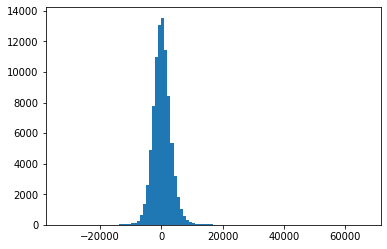

In [322]:
plt.hist(census2012['pop_change'], bins = 100);

In [323]:
df.groupby(by='state')[['pop_change']].sum().sort_values('pop_change')

,pop_change
state,
Michigan,-118171
Illinois,-88777
Hawaii,-87956
New York,-77200
West Virginia,-33176
Maine,-19665
Connecticut,-13422
Rhode Island,-9955
Mississippi,-2715


In [324]:
df.groupby(by='county')[['pop_change']].sum().sort_values('pop_change').head()

,pop_change
county,
San Bernardino County,-683714
Orange County,-577311
New York County,-538966
Gwinnett County,-465368
Franklin County,-312737


In [325]:
df[['geocode', 'pop_change']].sort_values('pop_change').tail(10)

,geocode,pop_change
15872,"Census Tract 1345.21, Los Angeles County, Cali...",29034
79974,"Census Tract 86.04, Dallas County, Texas: Summ...",32718
19259,"Census Tract 2379, Los Angeles County, Califor...",35135
11202,"Census Tract 2379, Los Angeles County, Califor...",35135
23945,"Census Tract 106.17, Miami-Dade County, Florid...",35334
78031,"Census Tract 217.19, Denton County, Texas: Sum...",37162
60503,"Census Tract 9659, Grant County, North Dakota:...",44102
77585,"Census Tract 20.01, Lubbock County, Texas: Sum...",47263
79027,"Census Tract 310, Hardin County, Texas: Summar...",55681
75897,"Census Tract 25, Travis County, Texas: Summary...",66591


In [326]:
df[['geocode', 'pop_change']].sort_values('pop_change').head(10)

,geocode,pop_change
6631,"Census Tract 187, San Diego County, California...",-32825
14688,"Census Tract 187, San Diego County, California...",-32825
76544,"Census Tract 6731.01, Fort Bend County, Texas:...",-28145
23479,"Census Tract 27.12, Sarasota County, Florida: ...",-27354
25595,"Census Tract 9112, Sumter County, Florida: Sum...",-24960
22526,"Census Tract 167.30, Orange County, Florida: S...",-24100
79092,"Census Tract 6920.01, Montgomery County, Texas...",-23260
6753,"Census Tract 133.1, San Diego County, Californ...",-22841
14810,"Census Tract 133.1, San Diego County, Californ...",-22841
54637,"Census Tract 462.01, Bronx County, New York: S...",-22819


In [327]:
df[['geocode', 'pop_change_perc']].sort_values('pop_change_perc').tail(10)

,geocode,pop_change_perc
12230,"Census Tract 9800.18, Los Angeles County, Cali...",1374.00
40031,"Census Tract 9800, Anne Arundel County, Maryla...",1440.60
71460,"Census Tract 9809, Philadelphia County, Pennsy...",1756.25
68242,"Census Tract 9809, Philadelphia County, Pennsy...",1756.25
24726,"Census Tract 9800, Monroe County, Florida: Sum...",1814.00
83052,"Census Tract 9802, Accomack County, Virginia: ...",1869.00
81145,"Census Tract 9802, Accomack County, Virginia: ...",1869.00
73634,"Census Tract 9802, Davidson County, Tennessee:...",2072.50
14331,"Census Tract 9800.09, Los Angeles County, Cali...",2685.50
6274,"Census Tract 9800.09, Los Angeles County, Cali...",2685.50


In [336]:
df[['geocode', 'pop_change_perc', 'total_population','2019_pop']].sort_values('pop_change_perc').head(10)

,geocode,pop_change_perc,total_population,2019_pop
24908,"Census Tract 10.01, Leon County, Florida: Summ...",-1.0,2934,0
39928,"Census Tract 340.02, York County, Maine: Summa...",-1.0,5144,0
39927,"Census Tract 302.01, York County, Maine: Summa...",-1.0,3131,0
39923,"Census Tract 360.01, York County, Maine: Summa...",-1.0,6972,0
35583,"Census Tract 5, Howard County, Indiana: Summar...",-1.0,3558,0
87018,"Census Tract 38, Milwaukee County, Wisconsin: ...",-1.0,2373,0
39913,"Census Tract 53, York County, Maine: Summary l...",-1.0,6869,0
35584,"Census Tract 2, Howard County, Indiana: Summar...",-1.0,3539,0
75117,"Census Tract 305.26, Collin County, Texas: Sum...",-1.0,7568,0
75137,"Census Tract 6.05, Lubbock County, Texas: Summ...",-1.0,767,0


In [338]:
df[df['2019_pop']==0]

,pct_in_poverty,pct_bachelors_degree,total_population,median_HH_income,pct_non_Hisp_white,pct_non_Hisp_black,pct_Hispanic,labor_force_part_rate,unemployment_rate,median_home_value,...,median_owner_costs_pct_of_income,median_renter_costs_pct_of_income,state,county,tract,id,pop_change,pop_change_perc,2019_pop,geocode
457,29.867568,9.563567,3549,26329,2,97,0,42,18,57700,...,22.7,49.4,Alabama,Jefferson County,005702,01073005702,-3549,-1.0,0,"Census Tract 57.02, Jefferson County, Alabama:..."
501,10.556622,13.781200,5762,54525,84,4,9,63,6,122700,...,17.8,25.4,Alabama,Chilton County,060401,01021060401,-5762,-1.0,0,"Census Tract 604.01, Chilton County, Alabama: ..."
773,24.153248,6.544294,1833,24091,49,50,0,52,19,69500,...,19.1,37.0,Alabama,Conecuh County,960500,01035960500,-1833,-1.0,0,"Census Tract 9605, Conecuh County, Alabama: Su..."
780,12.925227,19.474836,11953,62175,93,2,1,67,9,163200,...,19.0,25.5,Alabama,Mobile County,006502,01097006502,-11953,-1.0,0,"Census Tract 65.02, Mobile County, Alabama: Su..."
781,18.000905,5.584112,6633,44958,78,13,6,59,6,100400,...,18.5,37.9,Alabama,Mobile County,006701,01097006701,-6633,-1.0,0,"Census Tract 67.01, Mobile County, Alabama: Su..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88106,14.396600,16.966581,5418,47313,93,0,0,64,7,170600,...,24.2,31.3,Wisconsin,Polk County,960300,55095960300,-5418,-1.0,0,"Census Tract 9603, Polk County, Wisconsin: Sum..."
88128,40.982287,4.697157,2599,29943,1,94,3,54,25,75300,...,29.5,33.6,Wisconsin,Milwaukee County,006800,55079006800,-2599,-1.0,0,"Census Tract 68, Milwaukee County, Wisconsin: ..."
88214,24.813678,12.826511,4601,41100,96,0,2,58,6,125400,...,19.3,25.8,Wisconsin,Vernon County,960200,55123960200,-4601,-1.0,0,"Census Tract 9602, Vernon County, Wisconsin: S..."
88215,12.514092,21.354812,3555,50319,96,0,1,63,8,155500,...,21.5,25.7,Wisconsin,Vernon County,960500,55123960500,-3555,-1.0,0,"Census Tract 9605, Vernon County, Wisconsin: S..."
